# Aula 07: O "E se forem Palavras?" (Deep Learning para PLN)

**A Ponte:** Nas últimas aulas, ensinamos o computador a "ver" usando CNNs. O desafio era transformar pixels em conceitos. Agora, vamos ensinar o computador a "ler". O desafio é transformar *palavras* em *números* que capturem **significado** e **contexto**.

Uma CNN não funciona bem aqui. Por quê? Porque a ordem das palavras muda todo o significado. 

* `"O filme não foi bom."`
* `"O bom filme não foi... este."`

Precisamos de um modelo que não apenas veja as palavras, mas que as leia *em sequência*, como um humano, e que tenha **memória** do que veio antes.

**O Objetivo de Hoje:** Construir um modelo que possa ler uma crítica de filme e classificá-la como "Positiva" ou "Negativa" (Análise de Sentimentos).

## Módulo 1: O Problema de Transformar Palavras em Números

**O Desafio:** Como representar `"gato"` e `"cachorro"` como números?

**Abordagem Antiga (Bag-of-Words):** Criar um vetor gigante onde cada posição é uma palavra do dicionário. `gato = [0, 0, 1, 0, ...]`, `cachorro = [0, 1, 0, 0, ...]`. 
*Problema:* Esses vetores são gigantescos (milhões de posições) e não têm relação. O modelo não sabe que `gato` e `cachorro` são mais parecidos entre si do que com `"filme"`.

**Abordagem Deep Learning (Word Embeddings):** 
Esta é a ideia central. Em vez de um vetor gigante, vamos representar cada palavra como um vetor curto (ex: 100 números) de *significado*.

Nesse "espaço de significado", palavras parecidas ficarão próximas. A rede neural vai *aprender* esses vetores sozinha durante o treinamento. 

É o que permite a famosa analogia: `vetor('Rei') - vetor('Homem') + vetor('Mulher') ≈ vetor('Rainha')`.

## Módulo 2: A Rede com "Memória" (RNN e LSTM)

Já que a ordem importa, não podemos usar uma rede neural simples. Precisamos de uma **Rede Neural Recorrente (RNN)**.

* **RNN:** É uma rede com um "loop". Ela lê a primeira palavra (`"O"`), gera uma saída e passa sua "memória" para o próximo passo, quando lê a segunda palavra (`"filme"`).
* **Problema da RNN:** Ela tem "memória curta". Em uma crítica longa, ela esquece o que leu no início.
* **Solução (A que vamos usar):** **LSTM (Long Short-Term Memory)**. É um tipo de RNN superpoderosa com "portões" (gates) que permitem a ela decidir o que esquecer e o que guardar na memória de longo prazo.

**Nossa Estratégia de Modelo:**
1.  **Entrada:** A crítica (lista de números/índices de palavras).
2.  **Camada `Embedding`:** Transforma os índices de palavras em vetores de significado (aprendidos).
3.  **Camada `LSTM`:** Lê a sequência de vetores de significado e gera um "resumo" da crítica inteira.
4.  **Camada `Dense` (Saída):** Lê o resumo e classifica como 0 (Negativa) ou 1 (Positiva).

## Módulo 3: Configuração e Carga dos Dados (IMDb)

Vamos usar o dataset "IMDb", que já vem no Keras. Ele contém 50.000 críticas de filmes, já pré-processadas onde cada palavra já é um número (um índice).

`VOCAB_SIZE` = 10000 significa que só vamos carregar as 10.000 palavras mais frequentes. O resto será marcado como `<UNK>` (desconhecido).

In [1]:
# Garantir que estamos com o TF e TF-Metal corretos instalados
# (Os alunos já devem ter feito isso na aula passada)
# pip install tensorflow-macos tensorflow-metal

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

print(f"TensorFlow v{tf.__version__}")

/Users/leonardoraiz/Documents/Leonardo/FATEC/Aulas/IA/Outros/Aula 04 - Sistemas Especialistas /.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


TensorFlow v2.16.2


In [2]:
VOCAB_SIZE = 10000 # Tamanho do nosso "dicionário"

# Carregar os dados. As palavras já são números!
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=VOCAB_SIZE)

print(f"Temos {len(x_train)} críticas de treino e {len(x_test)} de teste.")

print("\n--- Exemplo de Crítica (como números) ---")
print(x_train[0])

print(
"--- Rótulo ---")
print(f"{y_train[0]} (Significa 'Positiva')")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Temos 25000 críticas de treino e 25000 de teste.

--- Exemplo de Crítica (como números) ---
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16

### Curiosidade: Decodificando a crítica

Vamos ver como é a crítica em texto. O Keras nos dá o "dicionário reverso".

In [3]:
# Pegar o dicionário palavra -> índice
word_index = keras.datasets.imdb.get_word_index()

# Os índices 0, 1, 2, 3 são reservados para <PAD>, <START>, <UNK>, <UNUSED>
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # <UNK> = Unknown (palavra desconhecida)
word_index["<UNUSED>"] = 3

# Criar o dicionário reverso: índice -> palavra
reverse_word_index = {v: k for k, v in word_index.items()}

# Função para decodificar
def decode_review(text_indices):
    # Retorna o texto, ou '?' se o índice não for encontrado
    return ' '.join([reverse_word_index.get(i, '?') for i in text_indices])

print("--- Crítica Decodificada ---")
print(decode_review(x_train[0]))

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
--- Crítica Decodificada ---
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile f

## Módulo 4: Pré-processamento (Padding)

As críticas têm tamanhos diferentes (algumas 50 palavras, outras 500). A rede neural precisa de entradas de **tamanho fixo**.

**Solução:** Vamos usar `pad_sequences` (Preenchimento).
1.  Definimos um `MAX_LEN` (ex: 250 palavras).
2.  Críticas com mais de 250 palavras serão *cortadas*.
3.  Críticas com menos de 250 palavras serão *preenchidas* com zeros (`<PAD>`).

In [4]:
MAX_LEN = 250 # Máximo de palavras por crítica

print(f"Tamanho da crítica 0 antes do padding: {len(x_train[0])} palavras")
print(f"Tamanho da crítica 1 antes do padding: {len(x_train[1])} palavras")

x_train_pad = pad_sequences(x_train, 
                            maxlen=MAX_LEN, 
                            padding='post') # 'post' = preenche com 0 no final

x_test_pad = pad_sequences(x_test, 
                           maxlen=MAX_LEN, 
                           padding='post')

print(f"\nTamanho da crítica 0 DEPOIS do padding: {len(x_train_pad[0])} palavras")
print(f"Tamanho da crítica 1 DEPOIS do padding: {len(x_train_pad[1])} palavras")

print("\n--- Crítica 1 (mais curta) com padding ---")
print(x_train_pad[1])

Tamanho da crítica 0 antes do padding: 218 palavras
Tamanho da crítica 1 antes do padding: 189 palavras

Tamanho da crítica 0 DEPOIS do padding: 250 palavras
Tamanho da crítica 1 DEPOIS do padding: 250 palavras

--- Crítica 1 (mais curta) com padding ---
[   1  194 1153  194 8255   78  228    5    6 1463 4369 5012  134   26
    4  715    8  118 1634   14  394   20   13  119  954  189  102    5
  207  110 3103   21   14   69  188    8   30   23    7    4  249  126
   93    4  114    9 2300 1523    5  647    4  116    9   35 8163    4
  229    9  340 1322    4  118    9    4  130 4901   19    4 1002    5
   89   29  952   46   37    4  455    9   45   43   38 1543 1905  398
    4 1649   26 6853    5  163   11 3215    2    4 1153    9  194  775
    7 8255    2  349 2637  148  605    2 8003   15  123  125   68    2
 6853   15  349  165 4362   98    5    4  228    9   43    2 1157   15
  299  120    5  120  174   11  220  175  136   50    9 4373  228 8255
    5    2  656  245 2350    5    4

## Módulo 5: Construindo e Treinando o Modelo (LSTM)

Agora vamos empilhar nossas camadas (como na aula de CNN).

1.  **`Embedding`**: Nossa camada de "significado". Ela vai transformar nossos 10.000 índices de palavras em vetores de 32 dimensões. Ela será treinada junto com o modelo.
2.  **`Bidirectional(LSTM(64))`**: Nossa camada de "memória". Usamos `Bidirectional` para que ela leia a crítica da esquerda-para-direita E da direita-para-esquerda (o que dá mais contexto).
3.  **`Dense`**: Camadas finais para a classificação.

In [5]:
EMBEDDING_DIM = 32 # Cada palavra será um vetor de 32 números

model = keras.Sequential([
    # 1. Camada de Input e Embedding
    # Ela pega os índices (de 0 a 9999) e transforma em vetores de 32 dimensões
    layers.Embedding(input_dim=VOCAB_SIZE, 
                     output_dim=EMBEDDING_DIM, 
                     input_length=MAX_LEN),
    
    # 2. A Camada de Memória (LSTM)
    # Bidirecional: lê a frase nos dois sentidos
    layers.Bidirectional(layers.LSTM(64)),
    
    # 3. Camadas de Classificação (como as que já conhecemos)
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5), # Dropout ajuda a evitar overfitting
    
    # 4. Camada de Saída (1 neurônio, 0 ou 1)
    # Usamos 'sigmoid' para classificação binária
    layers.Dense(1, activation='sigmoid')
])

model.summary()

# Compilar o modelo
model.compile(optimizer='adam', 
              loss='binary_crossentropy', # Loss para classificação binária
              metrics=['accuracy'])

/Users/leonardoraiz/Documents/Leonardo/FATEC/Aulas/IA/Outros/Aula 04 - Sistemas Especialistas /.venv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-11-03 14:54:49.614476: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-11-03 14:54:49.614571: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-11-03 14:54:49.614591: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.66 GB
2025-11-03 14:54:49.614778: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-03 14:54:49.614801: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> phys

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Treinar o modelo
print("Iniciando o treinamento do modelo de NLP...")

# Usamos os dados 'padronizados' (x_train_pad)
history = model.fit(x_train_pad, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_data=(x_test_pad, y_test),
                    verbose=1)

print("Treinamento Concluído!")

Iniciando o treinamento do modelo de NLP...
Epoch 1/5


2025-11-03 14:55:06.643478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - accuracy: 0.5903 - loss: 0.6496 - val_accuracy: 0.8439 - val_loss: 0.3771
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.8770 - loss: 0.3196 - val_accuracy: 0.8398 - val_loss: 0.3728
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 138ms/step - accuracy: 0.9131 - loss: 0.2413 - val_accuracy: 0.8686 - val_loss: 0.3087
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step - accuracy: 0.9372 - loss: 0.1848 - val_accuracy: 0.8688 - val_loss: 0.3364
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step - accuracy: 0.9518 - loss: 0.1494 - val_accuracy: 0.8657 - val_loss: 0.3796
Treinamento Concluído!


782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8685 - loss: 0.3710

Acurácia no teste (críticas inéditas): 86.57%


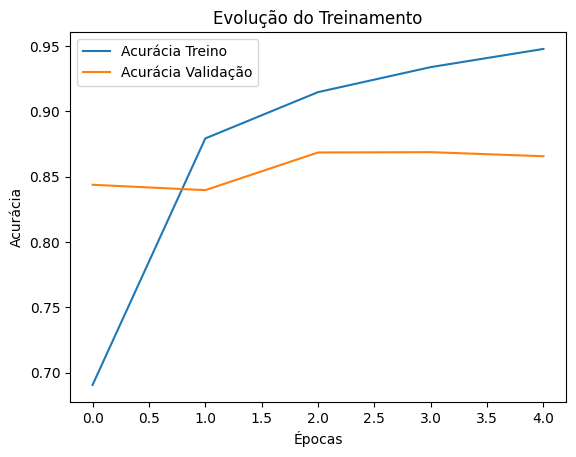

In [7]:
# Avaliar a acurácia final no set de teste
test_loss, test_acc = model.evaluate(x_test_pad, y_test)
print(f"\nAcurácia no teste (críticas inéditas): {test_acc*100:.2f}%")

# Plotar o gráfico de treinamento
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.title('Evolução do Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

## Módulo 6: Testando o Modelo com Nossas Próprias Frases

Esta é a parte mais legal. Vamos escrever nossas próprias frases e ver o que o modelo acha.

Precisamos de uma função que faça o pipeline completo:
1.  Limpar o texto.
2.  Transformar as palavras em índices (números).
3.  Aplicar o `padding` para ficar com 250 de tamanho.
4.  Fazer a previsão.

In [8]:
import re

def predict_sentiment(text):
    print(f"Avaliando: '{text}'")
    
    # 1. Limpar e "Tokenizar" o texto
    # (Transforma em minúsculas e pega apenas palavras)
    tokens = re.findall(r"\b\w+\b", text.lower())
    
    # 2. Transformar palavras em índices
    # Usamos .get(word, 2) para que palavras desconhecidas virem <UNK> (índice 2)
    indexed_tokens = [word_index.get(word, 2) for word in tokens]
    # Adicionar o <START> (índice 1) no começo
    indexed_tokens = [1] + indexed_tokens
    
    # 3. Aplicar o Padding
    # Note que [indexed_tokens] coloca a lista dentro de outra lista,
    # pois o pad_sequences espera um "lote" (batch) de frases.
    padded_text = pad_sequences([indexed_tokens], 
                                maxlen=MAX_LEN, 
                                padding='post')
    
    # 4. Fazer a previsão
    prediction = model.predict(padded_text)[0][0]
    
    # 5. Interpretar o resultado (sigmoid)
    if prediction >= 0.5:
        print(f"Resultado: POSITIVO ({prediction*100:.1f}%)\n")
    else:
        print(f"Resultado: NEGATIVO ({prediction*100:.1f}%)\n")

# Vamos testar!
predict_sentiment("This movie was absolutely amazing! The best film of the year.")
predict_sentiment("A complete waste of time. I fell asleep.")
predict_sentiment("It was not bad, actually quite good.")
predict_sentiment("The movie was okay. Not terrible, but not great either.")

Avaliando: 'This movie was absolutely amazing! The best film of the year.'
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
Resultado: POSITIVO (94.4%)

Avaliando: 'A complete waste of time. I fell asleep.'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Resultado: NEGATIVO (1.2%)

Avaliando: 'It was not bad, actually quite good.'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Resultado: NEGATIVO (26.1%)

Avaliando: 'The movie was okay. Not terrible, but not great either.'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Resultado: NEGATIVO (9.3%)



### Conclusão e Próximos Passos

Parabéns! Vocês construíram um modelo de Deep Learning que entende o sentimento em textos.

**O que aprendemos:**
1.  O desafio do NLP é transformar palavras em números que capturem **significado**.
2.  A camada `Embedding` aprende vetores de significado para cada palavra.
3.  A camada `LSTM` tem "memória" e é ideal para processar **sequências** como o texto.
4.  `pad_sequences` é essencial para padronizar o tamanho das entradas.

**Próximo Nível (O Futuro):**
O que fizemos é a base do NLP moderno. Hoje em dia, os modelos mais avançados (como o **GPT** ou o **BERT**) substituíram as LSTMs por uma arquitetura ainda mais poderosa chamada **Transformers**. Eles usam um mecanismo chamado "Atenção" para focar nas palavras mais importantes da frase, mas o princípio fundamental de "Embeddings" que aprendemos hoje continua sendo a base de tudo.